In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv(r'C:\Users\Sergio\Documents\github\AAPL-github.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-12-28,180.160004,181.330002,178.529999,179.289993,178.255447,79144300
1,2021-12-29,179.330002,180.630005,178.139999,179.380005,178.344940,62348900
2,2021-12-30,179.470001,180.570007,178.089996,178.199997,177.171722,59773000
3,2021-12-31,178.089996,179.229996,177.259995,177.570007,176.545395,64062300
4,2022-01-03,177.830002,182.880005,177.710007,182.009995,180.959732,104487900


In [3]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
signals.loc[signals['RollingMax'] < signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] > signals.trend, 'signal'] = 1
signals

,signal,trend,RollingMax,RollingMin
0,0.0,179.289993,NaN,NaN
1,0.0,179.380005,NaN,NaN
2,0.0,178.199997,NaN,NaN
3,0.0,177.570007,NaN,NaN
4,0.0,182.009995,NaN,NaN
...,...,...,...,...
248,0.0,135.449997,151.289993,132.300003
249,1.0,132.229996,151.289993,132.300003
250,1.0,131.860001,151.289993,132.229996
251,1.0,130.029999,151.289993,131.860001


In [4]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
   real_movement = movimiento real en el mundo real
    retraso = cuánto tiempo desea retrasar para cambiar nuestra decisión de comprar a vender, viceversa
    initial_state = 1 es comprar, 0 es vender
    initial_money = 1000, ignorar qué tipo de moneda
    max_buy = cantidad máxima para compartir para comprar
    max_sell = cantidad máxima de acciones para vender
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 48: buy 1 units at price 157.440002, total balance 9842.559998
day 51: buy 1 units at price 154.729996, total balance 9687.830002
day 52: buy 1 units at price 150.619995, total balance 9537.210007
day 60, sell 1 units at price 174.070007, investment 15.568990 %, total balance 9711.280014,
day 61, sell 1 units at price 174.720001, investment 16.000536 %, total balance 9886.000015,
day 62, sell 1 units at price 175.600006, investment 16.584791 %, total balance 10061.600021,
day 63: cannot sell anything, inventory 0
day 82: buy 1 units at price 156.800003, total balance 9904.800018
day 83: buy 1 units at price 156.570007, total balance 9748.230011
day 91: buy 1 units at price 152.059998, total balance 9596.170013
day 93: buy 1 units at price 146.500000, total balance 9449.670013
day 94: buy 1 units at price 142.559998, total balance 9307.110015
day 98: buy 1 units at price 140.820007, total balance 9166.290008
day 99: buy 1 units at price 137.350006, total balance 9028.940002
day 114:

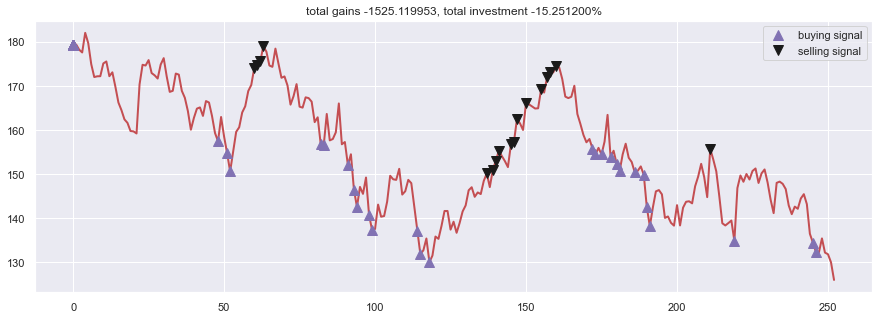

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()